In [1]:
# The following command is used to embed visual outputs in the notebook 
%matplotlib inline

# Load the python modules
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')
import imagedisplay

In [2]:
# Read the image
image = sitk.ReadImage( "../sample_data/image.nii.gz" )

### Convolving images with a kernel: Sobel and mean filtering

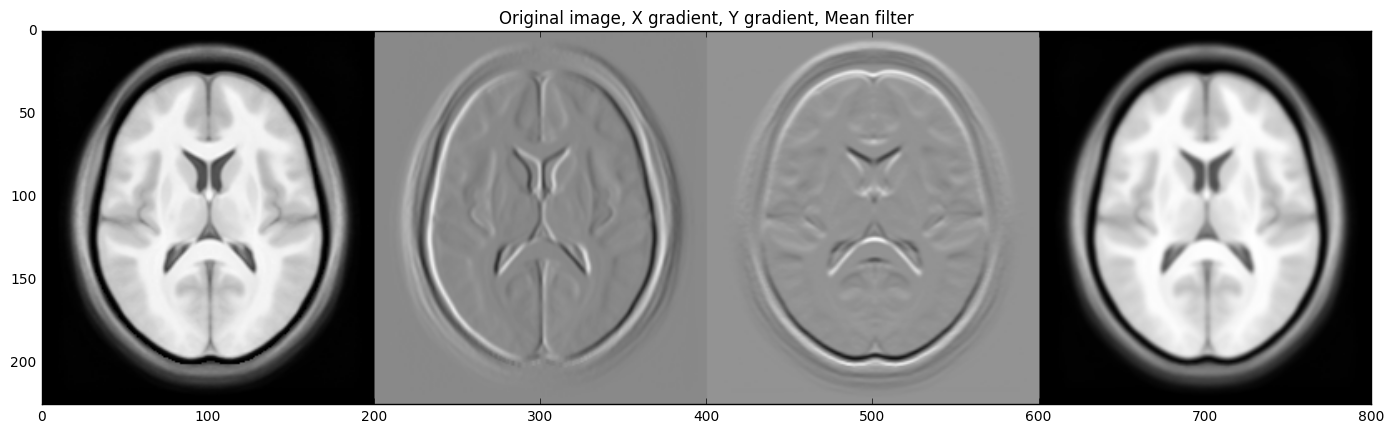

In [3]:
image =  sitk.Cast(image, sitk.sitkFloat32 )

# Create convolution filter object
conv = sitk.ConvolutionImageFilter()

# Sobel filter in X
filterX = sitk.Image( 3, 3, 3, sitk.sitkFloat32 )
for z in range( 0, filterX.GetSize()[2] ):
    for y in range( 0, filterX.GetSize()[1] ):
        filterX[0, y, z] = 1
        filterX[1, y, z] = 0
        filterX[2, y, z] = -1

# Sobel filter in Y
filterY = sitk.Image( 3, 3, 3, sitk.sitkFloat32 )
for z in range( 0, filterY.GetSize()[2] ):
    for x in range( 0, filterY.GetSize()[0] ):
        filterY[x, 0, z] = 1
        filterY[x, 1, z] = 0
        filterY[x, 2, z] = -1

# Mean filter
mean = sitk.Image( 3, 3, 3, sitk.sitkFloat32 )
for z in range( 0, mean.GetSize()[2] ):
    for y in range( 0, mean.GetSize()[1] ):
        for x in range( 0, mean.GetSize()[0] ):
            mean[x, y, z] = 1
            
# Convolve the image with different kernels
image2 = conv.Execute(image, filterX)
image3 = conv.Execute(image, filterY)
image4 = conv.Execute(image, mean)

# rescaling the intensities for better visualization
image = sitk.RescaleIntensity(image,0.0,255.0)
image2 = sitk.RescaleIntensity(image2,0.0,255.0)
image3 = sitk.RescaleIntensity(image3,0.0,255.0)
image4 = sitk.RescaleIntensity(image4,0.0,255.0)

imageSize = image.GetSize()
slices = [ image[:,:,imageSize[2]/2], 
           image2[:,:,imageSize[2]/2], 
           image3[:,:,imageSize[2]/2], 
           image4[:,:,imageSize[2]/2] ]
imagedisplay.myshow( sitk.Tile(slices, [4,1]),
                    title="Original image, X gradient, Y gradient, Mean filter",
                    dpi=16)

### Gaussian noise

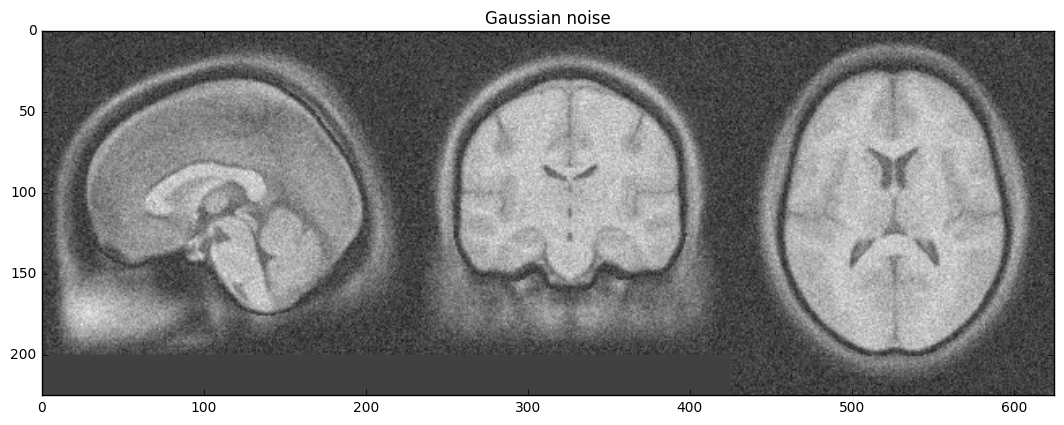

In [4]:
# Get a numpy array from a SimpleITK image
data = sitk.GetArrayFromImage(image) # numpy array

# Image dimensions
n_rows = imageSize[0]
n_cols = imageSize[1]
n_slices = imageSize[2]

# Add a gaussian noise to the image
mean = 0
sigma = max(data.flatten()) * 0.10
noise = np.random.normal(mean,sigma,(n_rows,n_cols,n_slices))
noisy_data = data + noise

# Put the numpy matrix back into a SimpleITK image object 
noisy_image = sitk.GetImageFromArray(noisy_data)
# Meta-information has to be copied from the original image:
# voxel spacing, orientation, and origin
sitk.Image.CopyInformation(noisy_image,image) 
 
slices =[ noisy_image[imageSize[0]/2,:,::-1],
          noisy_image[:,imageSize[1]/2,::-1],
          noisy_image[:,:,imageSize[2]/2] ]
imagedisplay.myshow(sitk.Tile(slices, [3,1]), title="Gaussian noise", dpi=21)

### Gaussian blurring

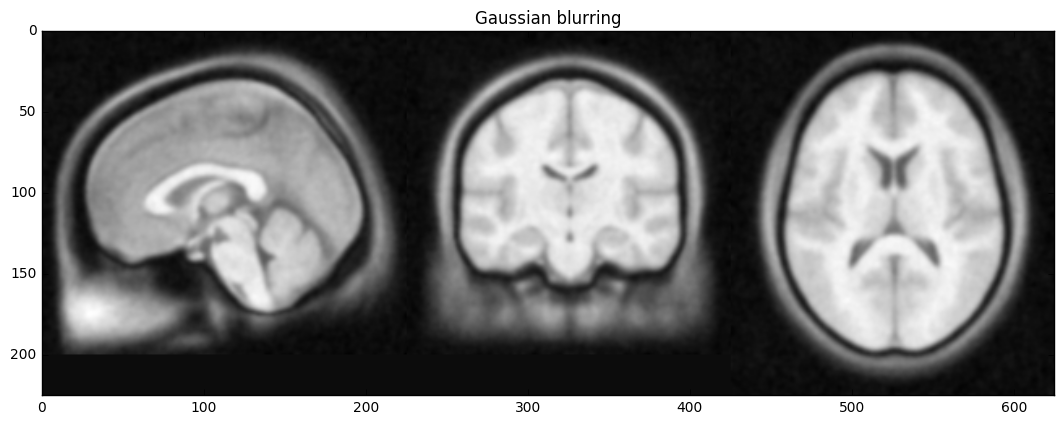

In [5]:
variance = 2.0
maximumKernelWidth = 10 # Maximum allowed kernel width 
                        # for any dimension of the discrete Gaussian approximation
maximumError = 0.01
useImageSpacing = True # The variance will be evaluated as pixel units if SetUseImageSpacing is off 
                       # or as physical units if SetUseImageSpacing is on

denoised_image = sitk.DiscreteGaussian(noisy_image,variance,maximumKernelWidth,maximumError,useImageSpacing)

slices = [ denoised_image[imageSize[0]/2,:,::-1],
           denoised_image[:,imageSize[1]/2,::-1],
           denoised_image[:,:,imageSize[2]/2] ]
imagedisplay.myshow(sitk.Tile(slices, [3,1]), title="Gaussian blurring", dpi=21)

### Anisotropic diffusion filtering

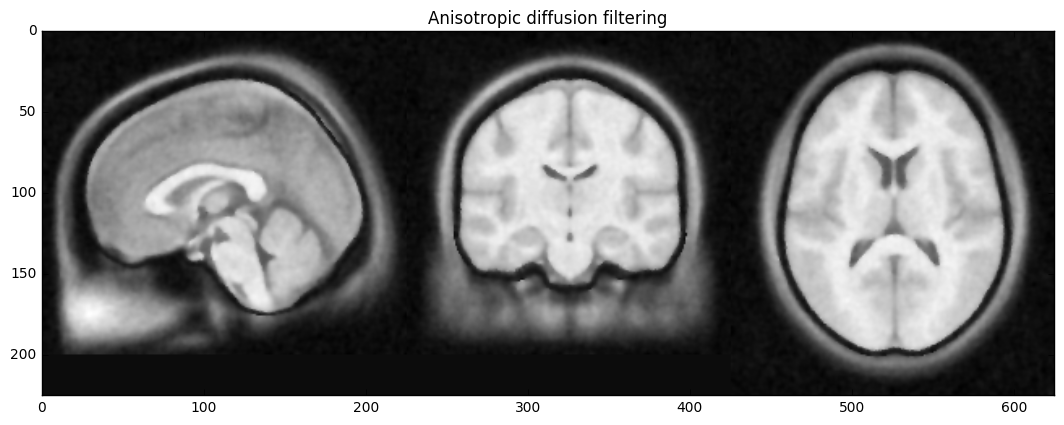

In [6]:
denoised_image = sitk.GradientAnisotropicDiffusion(noisy_image,0.120,3,1,6)
slices = [ denoised_image[imageSize[0]/2,:,::-1],
           denoised_image[:,imageSize[1]/2,::-1],
           denoised_image[:,:,imageSize[2]/2]]
imagedisplay.myshow(sitk.Tile(slices, [3,1]), title="Anisotropic diffusion filtering", dpi=21)

### Image downsampling

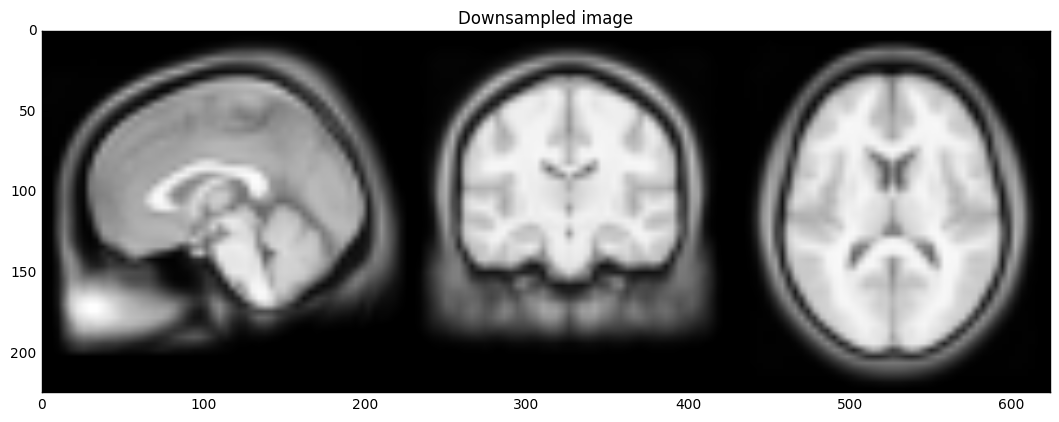

In [7]:
# Sampling Factor
sFactor = 4.0

# Perform lowpass filtering to avoid aliasing
variance = sFactor / 2.0
maximumKernelWidth = 7
maximumError = 0.01
useImageSpacing = False
blurred_image = sitk.DiscreteGaussian( image,
                                       variance,
                                       maximumKernelWidth,
                                       maximumError,
                                       useImageSpacing )

#By default a 3-d identity transform is constructed
transformation = sitk.Transform()

#A linear interpolation is selected for resampling
interpolator = sitk.sitkLinear

# Copy meta information
imageSize = image.GetSize()
imageSpacing = image.GetSpacing()

new_imageSize = [int(float(z)/sFactor) for z in imageSize]
new_imageOrigin = image.GetOrigin()
new_imageDirection = image.GetDirection() 
new_imageSpacing = [z*sFactor for z in imageSpacing]

# Perform resampling
resampled_image = sitk.Resample( blurred_image,
                                 new_imageSize,
                                 transformation,
                                 interpolator,
                                 new_imageOrigin,
                                 new_imageSpacing,
                                 new_imageDirection )

slices = [ resampled_image[new_imageSize[0]/2,:,::-1],
           resampled_image[:,new_imageSize[1]/2,::-1],
           resampled_image[:,:,new_imageSize[2]/2] ]
imagedisplay.myshow(sitk.Tile(slices, [3,1]), title="Downsampled image", dpi=5.25)

### Image Downsampling.v2 (using built-in resampler ob) 

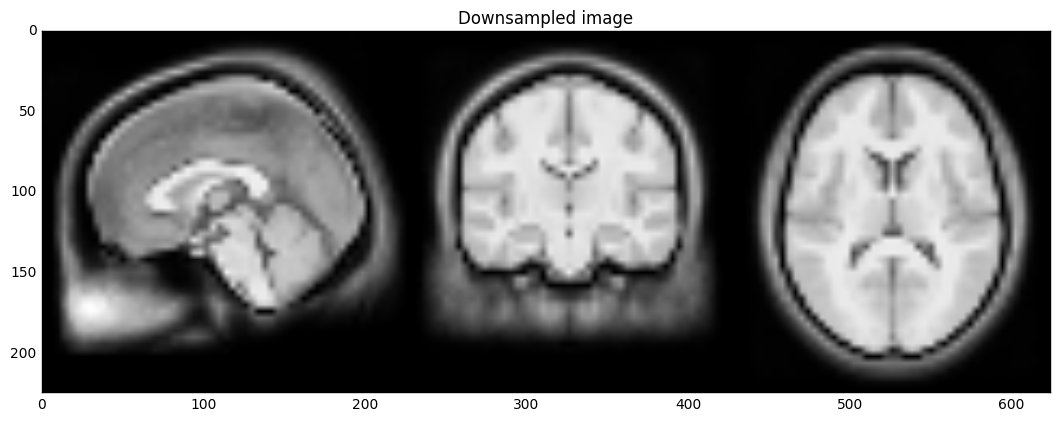

In [8]:
# create a resampler object
resampler = sitk.ResampleImageFilter()

# define the new resampling grid
origin = image.GetOrigin()
resampler.SetOutputOrigin(origin)

direction = image.GetDirection()
resampler.SetOutputDirection(direction)

# specify the new pixel spacing 
spacing    = list(image.GetSpacing())
spacing[0] = spacing[0] * 4
spacing[1] = spacing[1] * 4
spacing[2] = spacing[2] * 4
resampler.SetOutputSpacing(spacing)

# specify the number of voxels in each dimension
size = list(image.GetSize())
size[0] = int(size[0] / 4)
size[1] = int(size[1] / 4)
size[2] = int(size[2] / 4)
resampler.SetSize(size)

# resample
resampled_image = resampler.Execute(image)

# plot the resampled image
slices = [ resampled_image[size[0]/2,:,::-1],
           resampled_image[:,size[1]/2,::-1],
           resampled_image[:,:,size[2]/2] ]
imagedisplay.myshow(sitk.Tile(slices, [3,1]), title="Downsampled image", dpi=5.25)